# Efecto de distintos valores de learning rate $\alpha$

El valor del learning rate $\alpha$ determina la velocidad de aprendizaje. Si recordamos los parámetros se modificaban mediante la siguiente fórmula

$$\omega_i' = \omega_i - \alpha\frac{\partial loss}{\partial \omega_i}$$

Es decir el peso de la red se modifica restándole el gradiente de la función de coste multiplicado por el learning rate $\alpha$. Por lo que modificar este valor va a hacer que se modifique más o menos el valor del peso, es decir, que la red aprenda más o menos deprisa

Vamos e ver este efecto en el primer ejemplo de entrenamiento que vimos

Supongamos que tenemos la siguiente distribución de puntos

In [1]:
import numpy as np

x = np.array( [ 0.        ,  0.34482759,  0.68965517,  1.03448276,  1.37931034,
        1.72413793,  2.06896552,  2.4137931 ,  2.75862069,  3.10344828,
        3.44827586,  3.79310345,  4.13793103,  4.48275862,  4.82758621,
        5.17241379,  5.51724138,  5.86206897,  6.20689655,  6.55172414,
        6.89655172,  7.24137931,  7.5862069 ,  7.93103448,  8.27586207,
        8.62068966,  8.96551724,  9.31034483,  9.65517241, 10.        ])

y = np.array( [-0.16281253,  1.88707606,  0.39649312,  0.03857752,  4.0148778 ,
        0.58866234,  3.35711859,  1.94314906,  6.96106424,  5.89792585,
        8.47226615,  3.67698542, 12.05958678,  9.85234481,  9.82181679,
        6.07652248, 14.17536744, 12.67825433, 12.97499286, 11.76098542,
       12.7843083 , 16.42241036, 13.67913705, 15.55066478, 17.45979602,
       16.41982806, 17.01977617, 20.28151197, 19.38148414, 19.41029831])

Los representamos

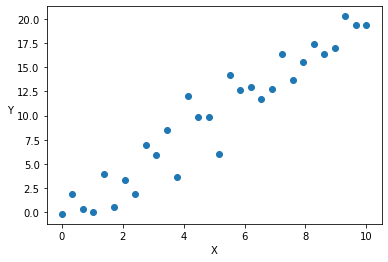

In [2]:
import matplotlib.pyplot as plt

plt.scatter(x, y)
plt.xlabel('X')
plt.ylabel('Y  ', rotation=0)
plt.show()

Queremos crear una red neuronal que se ajuste a esos puntos, así que hacemos todo el proceso

## Dataset y Dataloader

Creamos un dataset

In [3]:
import torch

class Dataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = torch.from_numpy(x).type(torch.float32).reshape((len(x), 1))
        self.y = torch.from_numpy(y).type(torch.float32).reshape((len(y), 1))

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [4]:
dataset = Dataset(x, y)

x.shape, y.shape, len(dataset)

((30,), (30,), 30)

In [5]:
sample = dataset[0]
x_sample, y_sample = sample

x_sample.dtype, y_sample.dtype

(torch.float32, torch.float32)

In [6]:
from torch.utils.data import DataLoader

BS = 1

dataloader = DataLoader(dataset, batch_size=BS)

In [7]:
batch = next(iter(dataloader))
sample_x, sample_y = batch
sample_x.shape, sample_y.shape

(torch.Size([1, 1]), torch.Size([1, 1]))

## Red neuronal

In [8]:
from torch import nn

class Model(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super().__init__()
        self.layer = torch.nn.Linear(num_inputs, num_outputs, bias=False)

    def forward(self, x):
        logits = self.layer(x)
        return logits

In [9]:
num_inputs = 1
num_outputs = 1
model = Model(num_inputs, num_outputs)

model

Model(
  (layer): Linear(in_features=1, out_features=1, bias=False)
)

In [10]:
for name, param in model.named_parameters():
    print(f"Capa: {name} | Size: {param.size()} | Value : {param[:2]} \n")

Capa: layer.weight | Size: torch.Size([1, 1]) | Value : tensor([[0.2580]], grad_fn=<SliceBackward0>) 



In [11]:
logits = model(sample_x)
logits.shape

torch.Size([1, 1])

In [12]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

model.to(device)

Using cuda device


Model(
  (layer): Linear(in_features=1, out_features=1, bias=False)
)

## Función de pérdida y optimizador

In [13]:
LR = 1e-3

loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)

## Ciclo de entrenamiento

In [14]:
num_prints = 4

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    
    for batch, (X, y) in enumerate(dataloader):
        # X and y to device
        X, y = X.to(device), y.to(device)

        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % int(len(dataloader)/(num_prints-1)) == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [15]:
epochs = 14
for t in range(epochs):
    print(f"Epoch {t+1}\n\t-------------------------------")
    train_loop(dataloader, model, loss_fn, optimizer)
print("Done!")

Epoch 1
	-------------------------------
loss: 0.026508  [    0/   30]
loss: 52.699287  [   10/   30]
loss: 31.265713  [   20/   30]
Epoch 2
	-------------------------------
loss: 0.026508  [    0/   30]
loss: 5.303040  [   10/   30]
loss: 0.043912  [   20/   30]
Epoch 3
	-------------------------------
loss: 0.026508  [    0/   30]
loss: 3.026393  [   10/   30]
loss: 0.754623  [   20/   30]
Epoch 4
	-------------------------------
loss: 0.026508  [    0/   30]
loss: 2.807850  [   10/   30]
loss: 0.890343  [   20/   30]
Epoch 5
	-------------------------------
loss: 0.026508  [    0/   30]
loss: 2.783537  [   10/   30]
loss: 0.906476  [   20/   30]
Epoch 6
	-------------------------------
loss: 0.026508  [    0/   30]
loss: 2.780777  [   10/   30]
loss: 0.908324  [   20/   30]
Epoch 7
	-------------------------------
loss: 0.026508  [    0/   30]
loss: 2.780466  [   10/   30]
loss: 0.908531  [   20/   30]
Epoch 8
	-------------------------------
loss: 0.026508  [    0/   30]
loss: 2.78

## Resultado

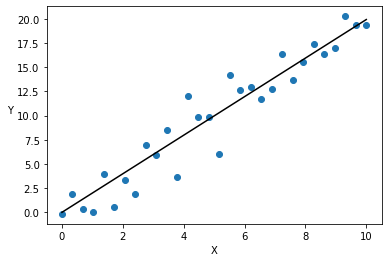

In [16]:
x_tensor = torch.from_numpy(x).type(torch.float32).reshape((len(x), 1))
model.to("cpu")
z = model(x_tensor).detach().numpy()
x_tensor.shape, z.shape

plt.scatter(x, y)
plt.plot(x, z, 'k')
plt.xlabel('X')
plt.ylabel('Y  ', rotation=0)
plt.show()

## Varios LR

Volvemos a crear la red neuronal desde cero y probamos a entrenarla con varios LRs

In [17]:
LRs = [1e-3, 1e-4, 2.5e-2]

Vamos a representar la pérdida en función de los posibles valores del peso de la red

In [18]:
# all x of dataset


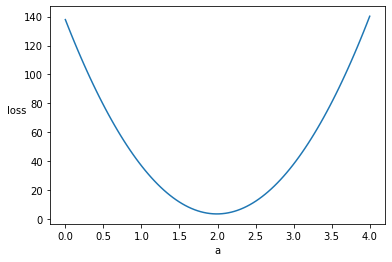

In [26]:
posibles_a = np.linspace(0, 4, 100)
perdidas = np.empty_like(posibles_a)
x_tensor = torch.from_numpy(x).type(torch.float32).reshape((len(x), 1))
y_tensor = torch.from_numpy(y).type(torch.float32).reshape((len(y), 1))

for i in range (len(posibles_a)):
    model.layer.weight.data = torch.tensor([[posibles_a[i]]]).type(torch.float32)
    z = model(x_tensor)
    perdidas[i] = loss_fn(z, y_tensor)

plt.plot(posibles_a, perdidas)
plt.xlabel('a')
plt.ylabel('loss  ', rotation=0)
plt.show()

Redefinimos la función de entrenamiento

In [27]:
num_prints = 2

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    
    for batch, (X, y) in enumerate(dataloader):
        # X and y to device
        X, y = X.to(device), y.to(device)

        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        print(f"loss = {loss}, a = {model.layer.weight.item()}")

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % int(len(dataloader)/(num_prints-1)) == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"\t\tloss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        
    return loss

In [28]:
def entrenamiento(epochs, dataloader, model, loss_fn, optimizer):
    # Matriz donde guardaremos la salida de la red cada epoch
    Zs = np.empty((epochs, len(x), 1))

    # Matriz donde se guardarán los errores de cada epoch
    Errores = np.empty(epochs)

    # Matriz donde guardaremos los pesos de cada epoch y para cada LR
    pesos = np.empty(epochs)
    
    for e in range(epochs):
        print(f"\tEpoch {e+1}\n-------------------------------")
        Errores[e] = train_loop(dataloader, model, loss_fn, optimizer)
        Zs[e] = model(x_tensor.to(device)).to("cpu").detach().numpy()
        # pesos[e] = model.layer.weight.data.numpy()
        print(f"pesos: {model.layer.weight.data.item():>7f}")
        pesos[e] = model.layer.weight.data.item()
    print("Done!")
    
    return Zs, Errores, pesos

In [29]:
import copy

# Modelo con los pesos inicializados aleatoriamente
model = Model(num_inputs, num_outputs)

# Matriz donde guardaremos las salidas de la red en cada epoch y para cada LR
Zs = np.empty((len(LRs), epochs, len(x), 1))

# Matriz donde se guardarán los errores de cada epoch y para cada LR
Errores = np.empty((len(LRs), epochs))

# Matriz donde guardaremos los pesos de cada epoch y para cada LR
pesos = np.empty((len(LRs), epochs))

epochs = 14
for i, LR in enumerate(LRs):
    # Se copia la red neuronal original y se manda a la GPU
    model_copy = copy.deepcopy(model).to(device)

    # Se define el optimizador
    optimizer = torch.optim.SGD(model_copy.parameters(), lr=LR)

    # Se entrena la red
    print(f"Entramiento para LR = {LR}")
    model_copy.to(device)
    Zs[i], Errores[i], pesos[i] = entrenamiento(epochs, dataloader, model_copy, loss_fn, optimizer)
    print("")

    # Se mueve la red neuronal entrenada a la CPU
    model_copy.to("cpu")

    # Se obtiene el logits de la red neuronal entrenada
    # logits = model_copy(x_tensor).detach().numpy()
    # Zs[i] = logits

Entramiento para LR = 0.001
	Epoch 1
-------------------------------
loss = 0.026507919654250145, a = -0.2583109140396118
		loss: 0.026508  [    0/   30]
loss = 3.9051637649536133, a = -0.2583109140396118
loss = 0.3291301429271698, a = -0.2569480538368225
loss = 0.09215307980775833, a = -0.2561567425727844
loss = 19.073579788208008, a = -0.25552865862846375
loss = 1.0169854164123535, a = -0.24348084628582
loss = 14.850828170776367, a = -0.24000340700149536
loss = 6.170140743255615, a = -0.2240571528673172
loss = 56.94321823120117, a = -0.21206553280353546
loss = 41.30443572998047, a = -0.17043203115463257
loss = 79.60936737060547, a = -0.13054122030735016
loss = 15.513653755187988, a = -0.06900736689567566
loss = 149.36488342285156, a = -0.03912728652358055
loss = 91.66799926757812, a = 0.06201610341668129
loss = 82.95626831054688, a = 0.1478550136089325
loss = 23.589427947998047, a = 0.23579464852809906
loss = 158.6900634765625, a = 0.2860383987426758
loss = 103.7673568725586, a = 0.4

In [30]:
# Creamos GIF con la evolución del entrenamiento

from matplotlib.animation import FuncAnimation

# Creamos la gráfica inicial
fig, ax = plt.subplots(3,2, figsize=(15,15))
ax2 = ax[0][1]
ax3 = ax[1][0]
ax4 = ax[1][1]
ax5 = ax[2][0]
ax6 = ax[2][1]
fig.set_tight_layout(True)
for i in range(3):
    ax[i][0].set_xlabel('X')
    ax[i][0].set_ylabel('Y  ', rotation=0)
    ax[i][1].set_xlabel('a')
    ax[i][1].set_ylabel('loss  ', rotation=0)

    # Se dibujan los datos que persistiran en toda la evolución de la gráfica
    ax[i][0].scatter(x, y)
    ax[i][1].plot(posibles_a, perdidas, linewidth = 3)

# Se dibuja el resto de lineas que irán cambiando durante el entrenamiento
line1, = ax[0][0].plot(x, Zs[0][0], 'k', linewidth=2)                             # Recta generada con la pendiente a aprendida
# line2, = ax2.plot(Xs_linea_gradiente[0,:], Ys_linea_gradiente[0,:], 'g')    # Gradiente de la función de error
punto2, = ax[0][1].plot(pesos[0][0], Errores[0][0], 'r*')                         # Punto donde se calcula el gradiente

line3, = ax[1][0].plot(x, Zs[1][0], 'k', linewidth=2)                             # Recta generada con la pendiente a aprendida
punto4, = ax[1][1].plot(pesos[1][0], Errores[1][0], 'r*')                         # Punto donde se calcula el gradiente

line5, = ax[2][0].plot(x, Zs[2][0], 'k', linewidth=2)                             # Recta generada con la pendiente a aprendida
punto6, = ax[2][1].plot(pesos[2][0], Errores[2][0], 'r*')                         # Punto donde se calcula el gradiente

# Se dibujan textos dentro de la segunda figura del subplot
fontsize = 12
a_text2 = ax[0][1].text(1, 90, f'pesos = {pesos[0][0]:.5f}', fontsize = fontsize)
error_text2 = ax[0][1].text(1, 80, f'loss = {Errores[0][0]:.5f}', fontsize = fontsize)
a_text4 = ax[1][1].text(1, 90, f'pesos = {pesos[1][0]:.2f}', fontsize = fontsize)
error_text4 = ax[1][1].text(1, 80, f'loss = {Errores[1][0]:.5f}', fontsize = fontsize)
a_text6 = ax[2][1].text(1, 90, f'pesos = {pesos[2][0]:.2f}', fontsize = fontsize)
error_text6 = ax[2][1].text(1, 80, f'loss = {Errores[2][0]:.5f}', fontsize = fontsize)

# Se dibuja un título
titulo = fig.suptitle(f'step: {0}', fontsize=fontsize)

# Se define la función que va a modificar la gráfica con la evolución del entrenamiento
def update(i):
    label = f'step {i}'

    # Se actualiza la linea 1. Recta generada con la pendiente a aprendida
    line1.set_ydata(Zs[0][i])
    line3.set_ydata(Zs[1][i])
    line5.set_ydata(Zs[2][i])
    
    # Se actualiza la linea 2. Gradiente de la función de error
    # line2.set_xdata(Xs_linea_gradiente[i,:])
    # line2.set_ydata(Ys_linea_gradiente[i,:])

    # Se actualiza el punto 2. Punto donde se calcula el gradiente
    punto2.set_xdata(pesos[0][i])
    punto2.set_ydata(Errores[0][i])
    punto4.set_xdata(pesos[1][i])
    punto4.set_ydata(Errores[1][i])
    punto6.set_xdata(pesos[2][i])
    punto6.set_ydata(Errores[2][i])

    # Se actualizan los textos
    a_text2.set_text(f'pesos = {pesos[0][i]:.5f}')
    error_text2.set_text(f'loss = {Errores[0][i]:.5f}')
    a_text4.set_text(f'pesos = {pesos[1][i]:.5f}')
    error_text4.set_text(f'loss = {Errores[1][i]:.5f}')
    a_text6.set_text(f'pesos = {pesos[2][i]:.5f}')
    error_text6.set_text(f'loss = {Errores[2][i]:.5f}')
    titulo.set_text(f'step: {i}')

    return line1, # ax1, #line2, punto2, ax2, a_text, error_text

# Se crea la animación con un refresco cada 200 ms
interval = 400 # ms
anim = FuncAnimation(fig, update, frames=np.arange(0, epochs), interval=interval)

# Se guarda en un GIF
gif_name = "GIFs/efecto_LRs.gif"
anim.save(gif_name, dpi=80, writer='imagemagick')
plt.close()

MovieWriter imagemagick unavailable; using Pillow instead.


![gif](GIFs/efecto_LRs.gif)

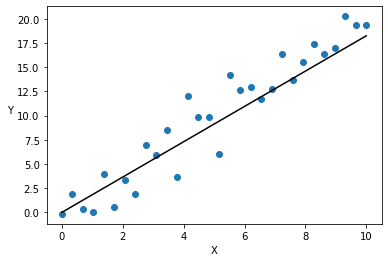

In [24]:
plt.scatter(x, y)
plt.plot(x, Zs[1][13], 'k')
plt.xlabel('X')
plt.ylabel('Y  ', rotation=0)
plt.show()

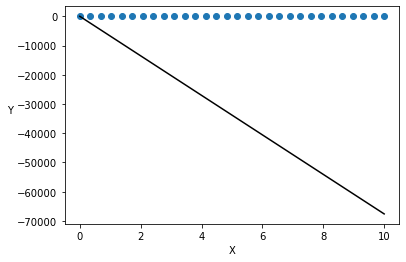

In [25]:
plt.scatter(x, y)
plt.plot(x, Zs[2][13], 'k')
plt.xlabel('X')
plt.ylabel('Y  ', rotation=0)
plt.show()